In [112]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

In [95]:
tweets = pd.read_csv('data-text-preprocessing.csv', usecols=["content_clean", "author_username", "created_at"])
tweets.columns = ["Tweet", "User", "Time"]

tweets = tweets.assign(Time=pd.to_datetime(tweets.Time))
print("Number of tweets: ",len(tweets['Tweet']))
tweets.head(5)

Number of tweets:  109705


Tweet                                               User  \
0  MariBerlomba  lomba poster ilmiah energi baruterbarukan dead...   
1     vegaaulia  elaahhh ini si bapak tiba ngomong soal energi ...   
2       enbater  masih banyak daerah terpencil membutuhkam list...   
3  imronrosidin  gw kira kalo gak tertarik dgn materi energi ba...   
4      revozone  satu lagi yang aneh inget jatropa alias minyak...   

                 Time  
0 2012-01-01 23:32:20  
1 2012-01-02 15:17:39  
2 2012-01-04 00:40:06  
3 2012-01-09 15:29:37  
4 2012-01-11 03:11:53

In [96]:
tweets['Time'] = pd.to_datetime(tweets['Time'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['Time']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity Over Years',
    height=450,
    width=1200,
    xaxis=dict(
        title='Month and year'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [98]:
corpus=[]
a=[]
for i in range(len(tweets['Tweet'])):
        a=tweets['Tweet'][i]
        corpus.append(a)
        
corpus[0:10]

['MariBerlomba',
 'vegaaulia',
 'enbater',
 'imronrosidin',
 'revozone',
 'Berita_Baru',
 'gertrudishrani',
 'gamaufiz',
 'sharpindonesia',
 'faldhan']

In [99]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


Folder "/var/folders/ql/17t5tp294714_4dzbm4dmz640000gn/T" will be used to save temporary dictionary and corpus.


In [100]:
# removing common words and tokenizing
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference

#print(dictionary)
#print(dictionary.token2id)

2022-07-29 17:07:35,186 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2022-07-29 17:07:35,220 : INFO : adding document #10000 to Dictionary<5140 unique tokens: ['mariberlomba', 'vegaaulia', 'enbater', 'imronrosidin', 'revozone']...>
2022-07-29 17:07:35,251 : INFO : adding document #20000 to Dictionary<7562 unique tokens: ['mariberlomba', 'vegaaulia', 'enbater', 'imronrosidin', 'revozone']...>
2022-07-29 17:07:35,286 : INFO : adding document #30000 to Dictionary<10923 unique tokens: ['mariberlomba', 'vegaaulia', 'enbater', 'imronrosidin', 'revozone']...>
2022-07-29 17:07:35,327 : INFO : adding document #40000 to Dictionary<14588 unique tokens: ['mariberlomba', 'vegaaulia', 'enbater', 'imronrosidin', 'revozone']...>
2022-07-29 17:07:35,358 : INFO : adding document #50000 to Dictionary<19769 unique tokens: ['mariberlomba', 'vegaaulia', 'enbater', 'imronrosidin', 'revozone']...>
2022-07-29 17:07:35,392 : INFO : adding document #60000 to Dictionary<24564 unique tokens: ['ma

In [101]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)  # store to disk, for later use


2022-07-29 17:07:44,015 : INFO : storing corpus in Matrix Market format to /var/folders/ql/17t5tp294714_4dzbm4dmz640000gn/T/elon.mm
2022-07-29 17:07:44,016 : INFO : saving sparse matrix to /var/folders/ql/17t5tp294714_4dzbm4dmz640000gn/T/elon.mm
2022-07-29 17:07:44,017 : INFO : PROGRESS: saving document #0
2022-07-29 17:07:44,035 : INFO : PROGRESS: saving document #1000
2022-07-29 17:07:44,039 : INFO : PROGRESS: saving document #2000
2022-07-29 17:07:44,044 : INFO : PROGRESS: saving document #3000
2022-07-29 17:07:44,049 : INFO : PROGRESS: saving document #4000
2022-07-29 17:07:44,056 : INFO : PROGRESS: saving document #5000
2022-07-29 17:07:44,064 : INFO : PROGRESS: saving document #6000
2022-07-29 17:07:44,075 : INFO : PROGRESS: saving document #7000
2022-07-29 17:07:44,083 : INFO : PROGRESS: saving document #8000
2022-07-29 17:07:44,094 : INFO : PROGRESS: saving document #9000
2022-07-29 17:07:44,106 : INFO : PROGRESS: saving document #10000
2022-07-29 17:07:44,113 : INFO : PROGRESS

In [102]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2022-07-29 17:07:53,188 : INFO : collecting document frequencies
2022-07-29 17:07:53,190 : INFO : PROGRESS: processing document #0
2022-07-29 17:07:53,195 : INFO : PROGRESS: processing document #10000
2022-07-29 17:07:53,200 : INFO : PROGRESS: processing document #20000
2022-07-29 17:07:53,204 : INFO : PROGRESS: processing document #30000
2022-07-29 17:07:53,209 : INFO : PROGRESS: processing document #40000
2022-07-29 17:07:53,219 : INFO : PROGRESS: processing document #50000
2022-07-29 17:07:53,238 : INFO : PROGRESS: processing document #60000
2022-07-29 17:07:53,249 : INFO : PROGRESS: processing document #70000
2022-07-29 17:07:53,259 : INFO : PROGRESS: processing document #80000
2022-07-29 17:07:53,266 : INFO : PROGRESS: processing document #90000
2022-07-29 17:07:53,275 : INFO : PROGRESS: processing document #100000
2022-07-29 17:07:53,358 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 109705 documents and 34370 features (109705 matrix non-zeros)', 'datetim

In [103]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [104]:
total_topics = 5

In [105]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2022-07-29 17:08:11,761 : INFO : using symmetric alpha at 0.2
2022-07-29 17:08:11,763 : INFO : using symmetric eta at 0.2
2022-07-29 17:08:11,770 : INFO : using serial LDA version on this node
2022-07-29 17:08:11,799 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 109705 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2022-07-29 17:08:11,801 : INFO : PROGRESS: pass 0, at document #2000/109705
2022-07-29 17:08:12,086 : INFO : merging changes from 2000 documents into a model of 109705 documents
2022-07-29 17:08:12,140 : INFO : topic #0 (0.200): 0.171*"ivancoid" + 0.059*"hijaukudotcom" + 0.017*"arjuned90" + 0.008*"twitpram" + 0.007*"_tanpanama__" + 0.007*"antarasumbar" + 0.005*"ug_hmte" + 0.005*"konphalindo" + 0.005*"ongkey_maulana" + 0.005*"solar_panel_ind"
2022-07-29 17:08:12,142 : INFO : topic #1 (0.200): 0.031*"ivancoid" + 0.012*"b

In [106]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.133*"energibaik_id" + 0.054*"zonaebt" + 0.037*"adidaya_id" + 0.031*"isalutem" + 0.028*"wikidpr1"'),
 (1,
  '0.030*"kontannews" + 0.025*"liputan6dotcom" + 0.018*"3_y4n4" + 0.016*"titikim2409" + 0.015*"3_yuniar"'),
 (2,
  '0.042*"cnbcindonesia" + 0.025*"republikaonline" + 0.018*"dodijusra" + 0.016*"b4_g4s" + 0.016*"mbokcilik1"'),
 (3,
  '0.076*"bisniscom" + 0.048*"wikidpr2" + 0.028*"1404stj" + 0.027*"katadatacoid" + 0.023*"petrominer_com"'),
 (4,
  '0.327*"rambuenergi" + 0.035*"duniaenergi" + 0.021*"jawapos" + 0.021*"ndarumadrito" + 0.018*"efisiensienergi"')]

In [107]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [108]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(5, 125)


In [109]:
df_lda

energibaik_id   zonaebt  adidaya_id  isalutem  wikidpr1  kementerianesdm  \
0       0.132722  0.054094    0.037318  0.031173  0.027648         0.020932   
1       0.000000  0.000000    0.000000  0.000000  0.000000         0.000000   
2       0.000000  0.000000    0.000000  0.000000  0.000000         0.000000   
3       0.000000  0.000000    0.000000  0.000000  0.000000         0.000000   
4       0.000000  0.000000    0.000000  0.000000  0.000000         0.000000   

    djebtke  mediaindonesia   ngabdul  plnuipsumbagut  ...  kontanonline  \
0  0.013424        0.011106  0.011016        0.010013  ...      0.000000   
1  0.000000        0.000000  0.000000        0.000000  ...      0.000000   
2  0.000000        0.000000  0.000000        0.000000  ...      0.000000   
3  0.000000        0.000000  0.000000        0.000000  ...      0.000000   
4  0.000000        0.000000  0.000000        0.000000  ...      0.004122   

    jpnncom  kabarberita  panasbumi_news  andri000me_15  jurnascom  \
0  0.000000     0.000000        0.000000       0.000000   0.000000   
1  0.000000     0.000000        0.000000       0.000000   0.000000   
2  0.000000     0.000000        0.000000       0.000000   0.000000   
3  0.000000     0.000000        0.000000       0.000000   0.000000   
4  0.004029     0.003717        0.003695       0.003322   0.003124   

   lokadataid  radarbangsa_com   kspgoid  swamediainc  
0    0.000000         0.000000  0.000000     0.000000  
1    0.000000         0.000000  0.000000     0.000000  
2    0.000000         0.000000  0.000000     0.000000  
3    0.000000         0.000000  0.000000     0.000000  
4    0.002787         0.002762  0.002695     0.002617  

[5 rows x 125 columns]

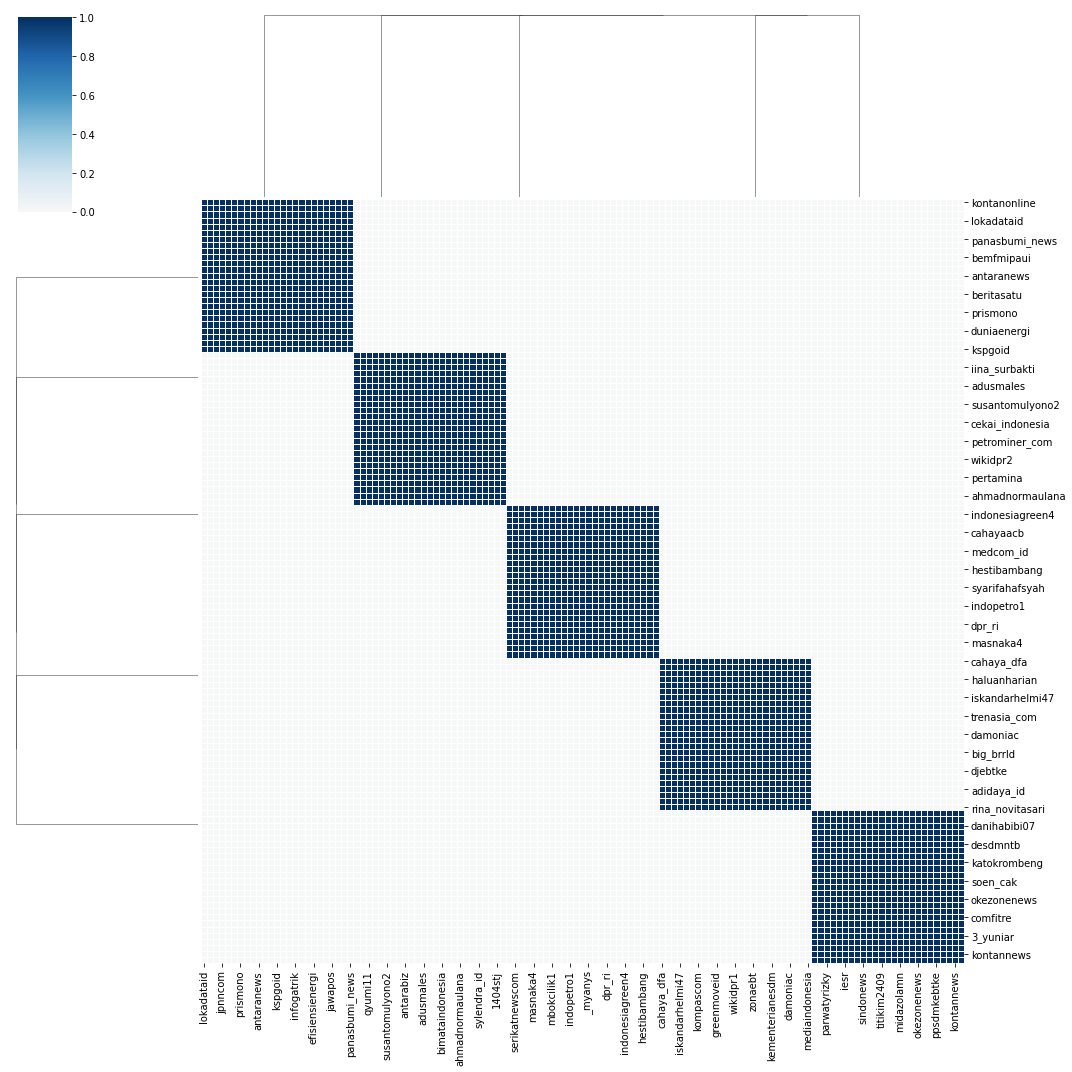

In [110]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [114]:
pyLDAvis.enable_notebook()
panel = gensimvis.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/Users/indralionardy/Personal/twitter/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/indralionardy/Personal/twitter/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/indralionardy/Personal/twitter/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/indralionardy/Personal/twitter/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/indra

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      150.222153  -72.269554       1        1  26.270675
4       51.163364 -159.968018       2        1  18.595325
1      -73.144554   21.523815       3        1  18.536307
2      -66.410133 -110.606438       4        1  18.379537
0       54.417324   12.443444       5        1  18.218156, topic_info=                Term         Freq        Total Category  logprob  loglift
7621     rambuenergi  6669.000000  6669.000000  Default  30.0000  30.0000
10709  energibaik_id  2653.000000  2653.000000  Default  29.0000  29.0000
323        bisniscom  2203.000000  2203.000000  Default  28.0000  28.0000
5943        wikidpr2  1387.000000  1387.000000  Default  27.0000  27.0000
11503        zonaebt  1081.000000  1081.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
10702     idnpos_com    64.174865    65.100174   Topic5  -5.7412   1.6884
10666     plnuidbali    53.443049    54.276662   Topic5  -5.9242   1.6873
10717        barep05    61.041671    62.047334   Topic5  -5.7912   1.6864
31040      big_brrld   137.132671   140.987312   Topic5  -4.9818   1.6750
31600       hutao707    61.873634    64.233696   Topic5  -5.7777   1.6653

[202 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
10161      1  0.998924          1404stj
13152      4  0.989763  21beritaterkini
12910      3  0.996441           3_y4n4
12909      3  0.997404         3_yuniar
13025      4  0.988447          _myanys
...      ...       ...              ...
10529      1  0.998286       wellylie99
5991       5  0.999243         wikidpr1
5943       1  0.999301         wikidpr2
7792       2  0.978194   wismaberitacom
11503      5  0.999106          zonaebt

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 3, 1])